<a href="https://colab.research.google.com/github/Zarak00/Projects/blob/main/Colorectal_Histology_Classification/Colorectal_Histology_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input

### Load Dataset

- We used TensorFlow Dataset (TFDS) to load the Colorectal Histology dataset. The dataset consists of 5000 images with 8 different tissue classes. We used **as_supervised=True** to get images and labels separetely

In [3]:
ds, info = tfds.load("colorectal_histology", as_supervised=True, with_info=True)
ds = ds["train"]  # The dataset provides a single "train" split

num_examples = info.splits["train"].num_examples
num_classes = info.features["label"].num_classes

print("Total samples:", num_examples)
print("Number of classes:", num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.XO66N3_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Total samples: 5000
Number of classes: 8


### Split the Dataset (80% Train, 20% Validation)
- The dataset provides only a single training split (no predefined validation set). We manually divided the dataset into 80% training and 20% validation

In [4]:
train_size = int(0.8 * num_examples)
train_ds = ds.take(train_size)
val_ds   = ds.skip(train_size)

### Visualize Images with Labels

- To ensure the dataset loaded correctly, we displayed 5 images with labels to verify images were correctly labeled before training

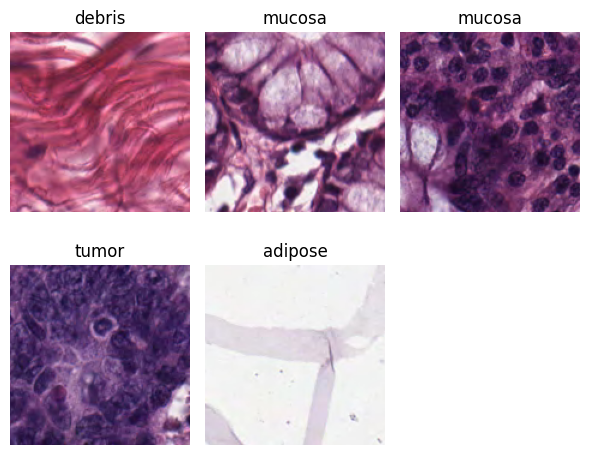

In [5]:
plt.figure(figsize=(6, 5))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(2, 3, i + 1)
    class_name = info.features["label"].int2str(label.numpy())
    plt.imshow(image.numpy())
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Preprocessing and Data Augmentation Functions
- Resized images to 224x224 to match the input size required by our pretrained CNN model. Used **preprocess_input()** which is specific to ImageNet models. This is done to match the pretrained models expected format improving performance

- Applied random transformation. These augmentations were applied only to train data to improve generalization and prevent overfitting

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation (applied only to training images)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

def train_preprocess(image, label):
    # Resize image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Apply data augmentation
    image = data_augmentation(image)
    # Preprocess using ResNet50's function (this rescales pixel values and applies any needed normalization)
    image = preprocess_input(image)
    return image, label

def val_preprocess(image, label):
    # Resize and preprocess (no augmentation)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    return image, label


### Configure the tf.data Pipelines
- Used tf.data pipeline optimizations
- **Autotune** optimizes performance by reducing data loading time


In [7]:
# Configure training dataset
train_ds = train_ds.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Configure validation dataset
val_ds = val_ds.map(val_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


### Build the Model
- Chose EfficientNetB0 (pretrained on ImageNet) as our CNN feature extractor.
- Built a Multi-Layer Perceptron (MLP) classification head:
- Global Average Pooling Layer (reduces features to a vector)
- Batch Normalization (improves stability)
- Dense Layer (128 neurons, ReLU activation)
- Dropout (50%) (prevents overfitting)
- Final Softmax Layer (for 8-class classification

In [8]:
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
# Freeze the base model initially
base_model.trainable = False

# Build the classification head
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,859,720 (91.02 MB)

 Trainable params: 267,656 (1.02 MB)

 Non-trainable params: 23,592,064 (90.00 MB)

### Compile the Model
- Compiled the model with Adam optimizer

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Train the Model and Monitor Learning Curves

In [11]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 404ms/step - accuracy: 0.7017 - loss: 0.9594 - val_accuracy: 0.8950 - val_loss: 0.3197
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8921 - loss: 0.3162 - val_accuracy: 0.9100 - val_loss: 0.2602
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.9343 - loss: 0.2104 - val_accuracy: 0.9260 - val_loss: 0.2160
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9412 - loss: 0.1574 - val_accuracy: 0.9320 - val_loss: 0.2091
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.9599 - loss: 0.1297 - val_accuracy: 0.9270 - val_loss: 0.2258
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9707 - loss: 0.0899 - val_accuracy: 0.9330 - val_loss: 0.2081
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9735 - loss: 0.0733 - val_accuracy: 0.9320 - val_loss: 0.2243
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9825 - loss: 0

In [16]:
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)

print(f"Final Training Accuracy: {train_accuracy:.4f}, Loss: {train_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9916 - loss: 0.0288
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9383 - loss: 0.2114
Final Training Accuracy: 0.9923, Loss: 0.0287
Final Validation Accuracy: 0.9390, Loss: 0.2259


### Visualizing learning curves:

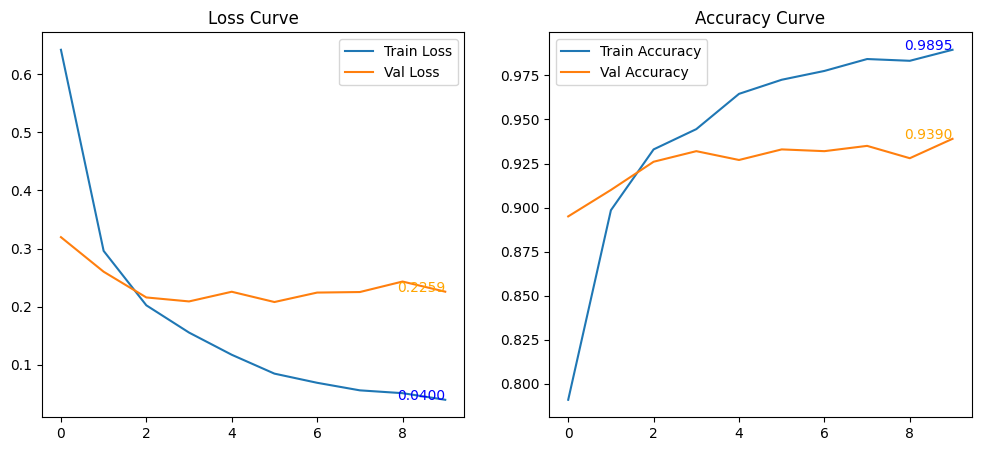

In [17]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

# Annotate final loss values
plt.text(len(loss) - 1, loss[-1], f"{loss[-1]:.4f}", ha="right", fontsize=10, color="blue")
plt.text(len(val_loss) - 1, val_loss[-1], f"{val_loss[-1]:.4f}", ha="right", fontsize=10, color="orange")

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Annotate final accuracy values
plt.text(len(acc) - 1, acc[-1], f"{acc[-1]:.4f}", ha="right", fontsize=10, color="blue")
plt.text(len(val_acc) - 1, val_acc[-1], f"{val_acc[-1]:.4f}", ha="right", fontsize=10, color="orange")

plt.show()


### Fine-Tuning the Model
Unfreeze the entire model (or selectively unfreeze some layers)
- Trained again for 10 additional epochs to improve accuracy

In [19]:
# Unfreeze the entire base model (or selectively unfreeze some layers)
base_model.trainable = True

# Optionally freeze some lower layers:
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 349ms/step - accuracy: 0.8061 - loss: 0.6775 - val_accuracy: 0.9040 - val_loss: 0.3465
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.9598 - loss: 0.1297 - val_accuracy: 0.8980 - val_loss: 0.3605
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - accuracy: 0.9840 - loss: 0.0556 - val_accuracy: 0.8990 - val_loss: 0.3375
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.9889 - loss: 0.0399 - val_accuracy: 0.9020 - val_loss: 0.3344
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 315ms/step - accuracy: 0.9961 - loss: 0.0228 - val_accuracy: 0.9020 - val_loss: 0.3291
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 315ms/step - accuracy: 0.9990 - loss: 0.0177 - val_accuracy: 0.9030 - val_loss: 0.3297
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 315ms/step - accuracy: 0.9974 - loss: 0.0160 - val_accuracy: 0.9020 - val_loss: 0.3247
Epoch 17/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 315ms/step - accuracy: 0.9996 

### Evaluate and Save the Final Model

In [20]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Final Validation Loss:", val_loss)
print("Final Validation Accuracy:", val_accuracy)

# Save the model for later use
model.save("colorectal_histology_model.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9012 - loss: 0.3555


Final Validation Loss: 0.3117242753505707
Final Validation Accuracy: 0.9070000052452087


### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

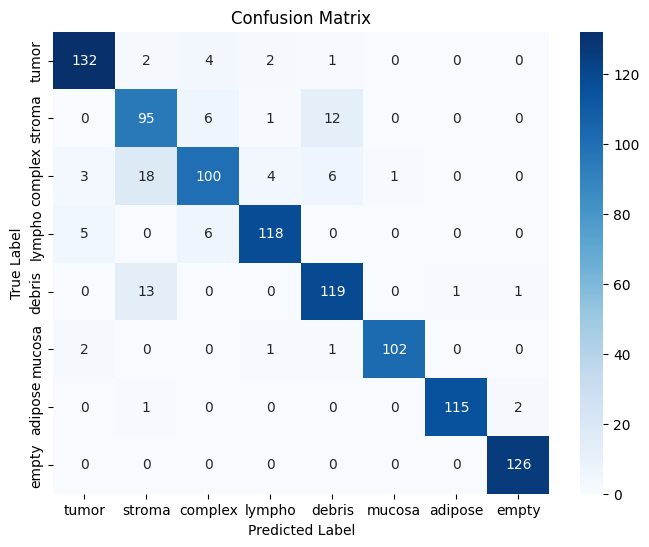

In [21]:
# Get True Labels and Predictions
y_true = []
y_pred = []

for images, labels in val_ds:  # Validation dataset
    preds = model.predict(images)  # Get model predictions
    y_true.extend(labels.numpy())  # Store true labels
    y_pred.extend(np.argmax(preds, axis=1))  # Store predicted class

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=info.features['label'].names,
            yticklabels=info.features['label'].names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
